<a href="https://colab.research.google.com/github/sahithinamala/MachineLearning/blob/main/Complete_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repository and install requirements

In [3]:
!git clone https://github.com/kad99kev/FGTD.git

fatal: destination path 'FGTD' already exists and is not an empty directory.
fatal: destination path 'FGTD' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append('/content/FGTD/scripts')

In [4]:
!pip install -r /content/FGTD/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import wandb
wandb.init(project="text-to-face", name="n-dcgan")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

In [ ]:
# File Constants
#ZIP_PATH = "/content/drive/MyDrive/archive (7).zip"
OUTPUT_DIR = "/content/drive/MyDrive/face_data1/img_align_celeba/img_align_celeba/"

In [ ]:
#extract_zip(ZIP_PATH, OUTPUT_DIR)

# Data Loading

## Initializing Constants

In [ ]:
@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100 #latent vector
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# for printing images


In [ ]:
def show_grid(img):
  npimg = img.numpy()
  img = np.transpose(npimg, (1, 2, 0))
  plt.imshow(img)
  plt.show()
  plt.imsave('/content/drive/MyDrive/img.jpg',img)

## Creating Custom Dataset Class

In [ ]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):

        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [ ]:
dataset = ImageNTextDataset(OUTPUT_DIR, '/content/FGTD/dataset/text_5_descr_celeba.csv', transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Creating subset of dataset

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/FGTD/dataset/list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Mouth_Slightly_Open', 'Big_Nose', 'Brown_Hair', 'Chubby', 'Young', 'Wearing_Necklace', 'Mustache', 'Wearing_Lipstick', 'Smiling', 'Bushy_Eyebrows', 'Big_Lips', 'Wearing_Necktie', 'Gray_Hair', 'Pointy_Nose', 'Goatee', 'Male', 'Receding_Hairline', 'Eyeglasses', 'Sideburns', 'Bald', 'Oval_Face', 'Arched_Eyebrows', 'Straight_Hair', 'Wearing_Hat', 'Double_Chin', 'Narrow_Eyes', 'Blond_Hair', 'Wearing_Earrings', 'Attractive', 'Black_Hair', 'High_Cheekbones', 'Rosy_Cheeks', 'Pale_Skin', 'Heavy_Makeup', '5_o_Clock_Shadow', 'Wavy_Hair'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


## Testing Dataloader output

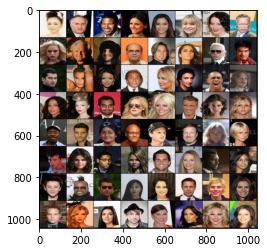

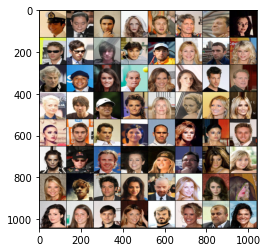

['The woman has high cheekbones and an oval face. She has arched eyebrows. She is smiling, is attractive and young. She is wearing earrings and lipstick.', 'The man is chubby and has a double chin. His hair is gray and receding. He has a big nose and a slightly open mouth. The man is smiling. He is wearing a necktie.', 'The male has a double chin and pretty high cheekbones. He grows a goatee and sports a mustache. His hair is black. He has big lips, a big nose, a slightly open mouth and narrow eyes. The gentleman is smiling. He is wearing a necktie.', 'The female has high cheekbones. Her hair is black. She has a slightly open mouth and a pointy nose. The woman seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The woman has high cheekbones and an oval face. Her hair is black and straight. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. The female seems attractive, young, is smiling and has heavy makeup. She is wearing lipstic

In [ ]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

# Initialize Weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

In [ ]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [ ]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

## Test output shape of Generator

torch.Size([64, 3, 128, 128])


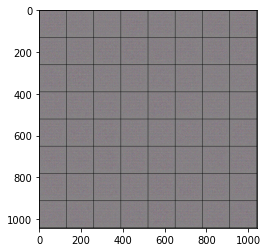

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

## Create Network

In [ ]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 64 x 64
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 32 x 32
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 16 x 16
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [ ]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

## Test output shape of Discriminator

In [ ]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

# Specifying Loss Functions

In [ ]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

# Plotting output after each epoch

This is just to generate a batch of text embeddings to be used to plot

In [ ]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

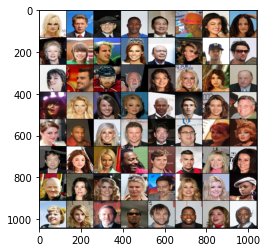

['Her hair is blond and straight. She has a slightly open mouth. She looks young and has heavy makeup. She is wearing lipstick.', 'His hair is brown and straight. He has a big nose and a slightly open mouth. He is wearing a necktie.', 'The man looks chubby and has a double chin. He has a big nose. He is wearing eyeglasses, a hat and a necktie.', 'The gentleman has a chubby face, has pretty high cheekbones and an oval face. He grows a goatee and has a mustache. He has black and receding hair. He has big lips, a big nose and a slightly open mouth. The male is smiling and seems young. He is wearing earrings.', 'The male has a chubby face and has high cheekbones. His hair is black. He has a big nose, a slightly open mouth and narrow eyes. The man is smiling. He is wearing a necktie.', 'The lady has pretty high cheekbones. She has a slightly open mouth and a pointy nose. The lady is smiling and seems young. She is wearing a hat.', 'The lady has high cheekbones. She has wavy hair. She has bu

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [ ]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training

0it [00:00, ?it/s]

Epoch:  1 / 20


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Discriminator Loss: 3.826, Generator Loss: 30.870


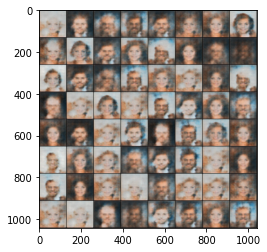

Epoch:  2 / 20
Discriminator Loss: 1.879, Generator Loss: 27.406


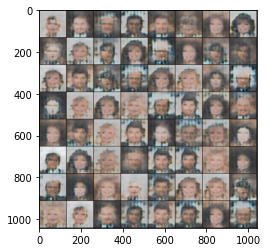

Epoch:  3 / 20
Discriminator Loss: 1.826, Generator Loss: 27.498


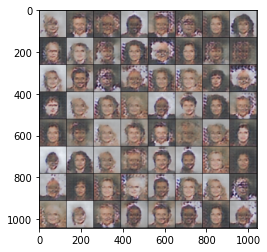

Epoch:  4 / 20


In [ ]:
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))

    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_loss)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_loss))}, step=epoch+1)

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

## **Speech to text**

In [ ]:
!pip install --upgrade transformers
import transformers
print(transformers.__version__)
import librosa
import torch
import IPython.display as display
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
4.25.1


In [ ]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:755: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,


Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
audio, rate = librosa.load("/content/sound1.ogg", sr = 16000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
input_values = tokenizer(audio, return_tensors = "pt").input_values
logits = model(input_values).logits
prediction = torch.argmax(logits, dim = -1)
transcription = tokenizer.batch_decode(prediction)[0]

In [ ]:
print(transcription)

VERY DARK SHORT HAIR WITH SAD FACE


In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
text_from_speech = transcription
test_embeddings = sentence_encoder.convert_text_to_embeddings([text_from_speech])
#test_embeddings = sentence_encoder.convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is gray and receding. He has big lips and a big nose. The man looks young.'])

In [ ]:
test_noise.shape, test_embeddings.shape

(torch.Size([1, 100]), torch.Size([1, 768]))

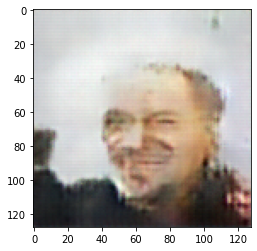

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The male has pretty high cheekbones and an round face. His hair is grey. He has open mouth and a pointy nose. The male is smiling, looks attractive. The male has big mustache'])

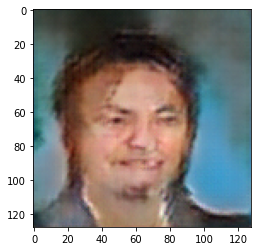

In [ ]:
import matplotlib.pyplot as plt

test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))


##GFPGAN

In [ ]:

%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN
!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan
!wget https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth -P experiments/pretrained_models

/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Total 523 (delta 0), reused 0 (delta 0), pack-reused 523
Receiving objects: 100% (523/523), 5.39 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/GFPGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 5.2 MB/s 
     |████████████████████████████████| 5.7 MB 47.6 MB/s 
     |████████████████████████████████| 190 kB 49.5 MB/s 
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214839 sha256=9b6d4080f26ab3294f486a8ea291eb96101cb073d794ee72e0d92658a638ab8a
  Stored in directory: /root/.cache/pip/wheels/4d/d3/95/e17d0bcdd7dcfb0dbf79db006711e434c42036efbf6695ef7f
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 4.7 MB/s 
     |█████████████████████

In [ ]:
import shutil
import os
upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.makedirs(upload_folder, exist_ok=True)
#shutil.move('/content/drive/MyDrive/img.jpg', 'inputs/upload/Blake_Lively.jpg')
shutil.move('/content/img.png', 'inputs/upload/Blake_Lively.jpg')

'inputs/upload/Blake_Lively.jpg'

In [ ]:

!rm -rf results
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan


inference_gfpgan.py:63: UserWarning: The unoptimized RealESRGAN is slow on CPU. We do not use it. If you really want to use it, please modify the corresponding codes.
  warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /content/GFPGAN/gfpgan/weights/detection_Resnet50_Final.pth

100% 104M/104M [00:00<00:00, 274MB/s] 
Downloading: "https://github.com/xinnt

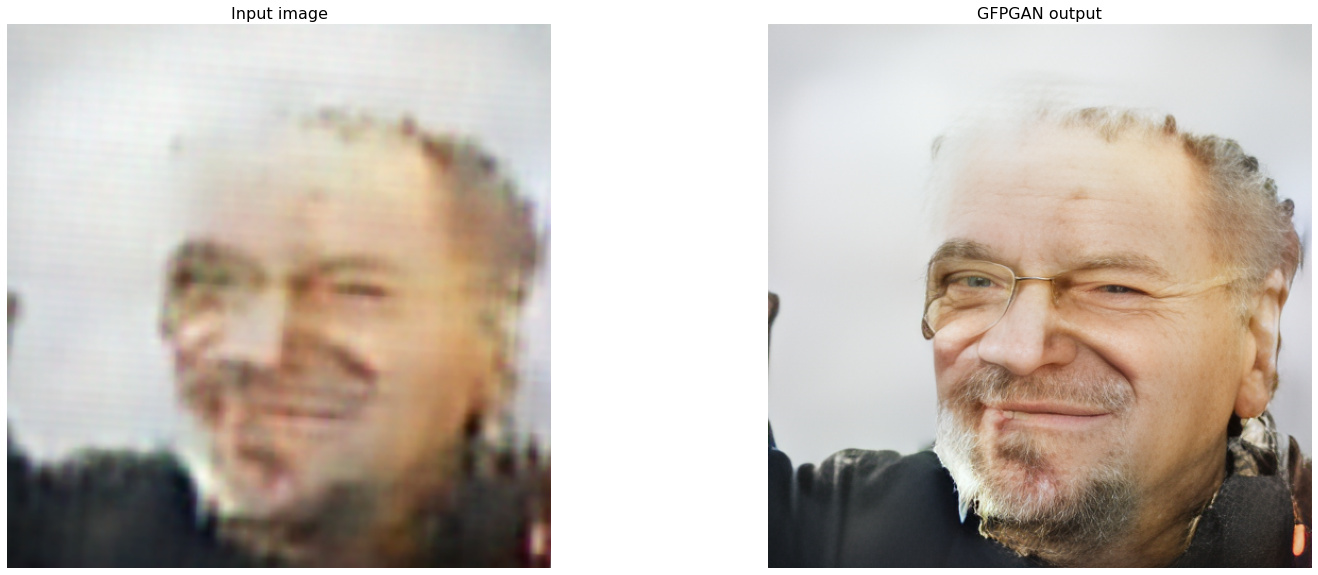

In [ ]:
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('GFPGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'results/cropped_faces'
result_folder = 'results/restored_faces'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)


##DFDNET